In [21]:
#https://www.pyimagesearch.com/2018/12/31/keras-conv2d-and-convolutional-layers/
import tensorflow as tf

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = '0' # Set to -1 if CPU should be used CPU = -1 , GPU = 0

gpus = tf.config.experimental.list_physical_devices('GPU')
cpus = tf.config.experimental.list_physical_devices('CPU')

if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)
elif cpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        logical_cpus= tf.config.experimental.list_logical_devices('CPU')
        print(len(cpus), "Physical CPU,", len(logical_cpus), "Logical CPU")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical CPU, 1 Logical CPU


In [22]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.regularizers import l2
# pip install imutils
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import cv2
import os
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dropout
from keras.layers.core import Dense
from keras import backend as K

In [23]:
class StridedNet:
	@staticmethod
	def build(width, height, depth, classes, reg, init="he_normal"):
		# initialize the model along with the input shape to be
		# "channels last" and the channels dimension itself
		model = Sequential()
		inputShape = (height, width, depth)
		chanDim = -1

		# if we are using "channels first", update the input shape
		# and channels dimension
		if K.image_data_format() == "channels_first":
			inputShape = (depth, height, width)
			chanDim = 1

		# our first CONV layer will learn a total of 16 filters, each
		# Of which are 7x7 -- we'll then apply 2x2 strides to reduce
		# the spatial dimensions of the volume
		model.add(Conv2D(16, (7, 7), strides=(2, 2), padding="valid", kernel_initializer=init, kernel_regularizer=reg, input_shape=inputShape))

		# here we stack two CONV layers on top of each other where
		# each layerswill learn a total of 32 (3x3) filters
		model.add(Conv2D(32, (3, 3), padding="same", kernel_initializer=init, kernel_regularizer=reg))
		model.add(Activation("relu"))
		model.add(BatchNormalization(axis=chanDim))
		model.add(Conv2D(32, (3, 3), strides=(2, 2), padding="same", kernel_initializer=init, kernel_regularizer=reg))
		model.add(Activation("relu"))
		model.add(BatchNormalization(axis=chanDim))
		model.add(Dropout(0.25))

		# stack two more CONV layers, keeping the size of each filter
		# as 3x3 but increasing to 64 total learned filters
		model.add(Conv2D(64, (3, 3), padding="same", kernel_initializer=init, kernel_regularizer=reg))
		model.add(Activation("relu"))
		model.add(BatchNormalization(axis=chanDim))
		model.add(Conv2D(64, (3, 3), strides=(2, 2), padding="same", kernel_initializer=init, kernel_regularizer=reg))
		model.add(Activation("relu"))
		model.add(BatchNormalization(axis=chanDim))
		model.add(Dropout(0.25))

		# increase the number of filters again, this time to 128
		model.add(Conv2D(128, (3, 3), padding="same", kernel_initializer=init, kernel_regularizer=reg))
		model.add(Activation("relu"))
		model.add(BatchNormalization(axis=chanDim))
		model.add(Conv2D(128, (3, 3), strides=(2, 2), padding="same", kernel_initializer=init, kernel_regularizer=reg))
		model.add(Activation("relu"))
		model.add(BatchNormalization(axis=chanDim))
		model.add(Dropout(0.25))

		# fully-connected layer
		model.add(Flatten())
		model.add(Dense(512, kernel_initializer=init))
		model.add(Activation("relu"))
		model.add(BatchNormalization())
		model.add(Dropout(0.5))

		# softmax classifier
		model.add(Dense(classes))
		model.add(Activation("softmax"))

		# return the constructed network architecture
		return model

In [24]:
# initialize the set of labels from the CALTECH-101 dataset we are
# going to train our network on
LABELS = set(["Faces", "Leopards", "Motorbikes", "airplanes"])

In [25]:
#imagedir = 'CALTECH101_ObjectCategories'
imagefilename = 'CALTECH101_ObjectCategories.zip'
import zipfile
print("[INFO] loading images...")
#imagePaths = list(paths.list_images(imagedir))
zf = zipfile.ZipFile(imagefilename)
imagelist = zf.namelist()
data = []
labels = []

[INFO] loading images...


In [26]:
# loop over the image paths
#for imagePath in imagePaths:
for imagePath in imagelist:
	# extract the class label from the filename
	#print(imagePath.split(os.path.sep), os.path.sep)
	#label = imagePath.split(os.path.sep)[-2]
	label = imagePath.split('/')[-2]

	# if the label of the current image is not part of of the labels
	# are interested in, then ignore the image
	if label not in LABELS:
		continue

	# load the image and resize it to be a fixed 96x96 pixels,
	# ignoring aspect ratio
	imagedata = zf.read(imagePath)
	#image = cv2.imread(imagePath)
	image = cv2.imdecode(np.frombuffer(imagedata, np.uint8), 1)
	image = cv2.resize(image, (96, 96))

	# update the data and labels lists, respectively
	data.append(image)
	labels.append(label)

In [27]:
# convert the data into a NumPy array, then preprocess it by scaling
# all pixel intensities to the range [0, 1]
data = np.array(data, dtype="float") / 255.0

In [28]:
# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)

In [29]:
# partition the data into training and testing splits using 75% of
# the data for training and the remaining 25% for testing
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.25, stratify=labels, random_state=42)

In [30]:
# construct the training image generator for data augmentation
aug = ImageDataGenerator(rotation_range=20, zoom_range=0.15, width_shift_range=0.2, height_shift_range=0.2, shear_range=0.15, horizontal_flip=True, fill_mode="nearest")

In [31]:
maxepoch = 100
# initialize the optimizer and model
print("[INFO] compiling model...")
opt = Adam(lr=1e-4, decay=1e-4 / maxepoch)
model = StridedNet.build(width=96, height=96, depth=3, classes=len(lb.classes_), reg=l2(0.0005))
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

[INFO] compiling model...


In [32]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 45, 45, 16)        2368      
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 45, 45, 32)        4640      
_________________________________________________________________
activation_9 (Activation)    (None, 45, 45, 32)        0         
_________________________________________________________________
batch_normalization_8 (Batch (None, 45, 45, 32)        128       
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 23, 23, 32)        9248      
_________________________________________________________________
activation_10 (Activation)   (None, 23, 23, 32)        0         
_________________________________________________________________
batch_normalization_9 (Batch (None, 23, 23, 32)       

In [34]:
# train the network
print("[INFO] training network for {} epochs...".format(maxepoch))
H = model.fit_generator(aug.flow(trainX, trainY, batch_size=10), validation_data=(testX, testY), steps_per_epoch=len(trainX) // 32, epochs=maxepoch, verbose=1)
#batch_size: 32->10 for small GPU memory

[INFO] training network for 100 epochs...
Epoch 1/100
52/52 [==============================] - 12s 235ms/step - loss: 1.6814 - accuracy: 0.6109 - val_loss: 1.4362 - val_accuracy: 0.6869
Epoch 2/100
52/52 [==============================] - 15s 284ms/step - loss: 1.5160 - accuracy: 0.6654 - val_loss: 1.6101 - val_accuracy: 0.6458
Epoch 3/100
52/52 [==============================] - 14s 263ms/step - loss: 1.5672 - accuracy: 0.6846 - val_loss: 1.5333 - val_accuracy: 0.6583
Epoch 4/100
52/52 [==============================] - 11s 216ms/step - loss: 1.4884 - accuracy: 0.6692 - val_loss: 1.4029 - val_accuracy: 0.6977
Epoch 5/100
52/52 [==============================] - 11s 211ms/step - loss: 1.2962 - accuracy: 0.7192 - val_loss: 1.2063 - val_accuracy: 0.7728
Epoch 6/100
52/52 [==============================] - 11s 202ms/step - loss: 1.3274 - accuracy: 0.7374 - val_loss: 1.1136 - val_accuracy: 0.8193
Epoch 7/100
52/52 [==============================] - 11s 209ms/step - loss: 1.3862 - accuracy:

In [35]:
# evaluate the network
print("[INFO] evaluating network...")
predictions = model.predict(testX, batch_size=32)
print(classification_report(testY.argmax(axis=1), predictions.argmax(axis=1), target_names=lb.classes_))

[INFO] evaluating network...
              precision    recall  f1-score   support

       Faces       0.99      0.98      0.99       109
    Leopards       1.00      0.30      0.46        50
  Motorbikes       0.93      1.00      0.96       200
   airplanes       0.87      0.96      0.91       200

    accuracy                           0.92       559
   macro avg       0.95      0.81      0.83       559
weighted avg       0.93      0.92      0.90       559



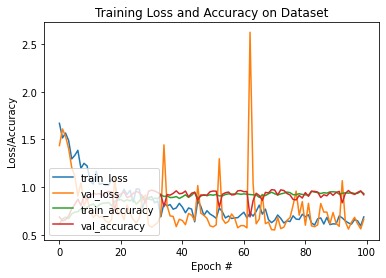

In [41]:
# plot the training loss and accuracy
import matplotlib
%matplotlib inline
plt.figure()
plt.plot(np.arange(0, maxepoch), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, maxepoch), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, maxepoch), H.history["accuracy"], label="train_accuracy")
plt.plot(np.arange(0, maxepoch), H.history["val_accuracy"], label="val_accuracy")
plt.title("Training Loss and Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.show()